# Banking Fraud Detection - Results Visualization

This notebook provides visualization and analysis of the banking fraud detection system results. We'll load the trained models, evaluate their performance, and create visualizations to better understand the effectiveness of each model. A common mistake for this type of problem would be to prioritize precision or accuracy. Through the analyisis, we'll see that due to class imbalance, a near perfect accuracy is achieved by classifiying every every transaction as fraud.
This project focuses on maximizing recall rates, while keeping the precision at a manageable level.

## 1. Setup and Data Loading

We start by loading the data (already transformed for analysis) and the raw data for distribution analysis and EDA

In [25]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split

# Set style for plots
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [13]:
# Import our project modules
from src.load_data import load_data

# Load data
X, y = load_data('data/fraud_data.csv')

# Create train-test split using the same parameters as in main.py
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Fraud cases in training set: {sum(y_train)} ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"Fraud cases in test set: {sum(y_test)} ({sum(y_test)/len(y_test)*100:.2f}%)")

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')
X_train shape: (4453834, 10), X_test shape: (1908786, 10)
Fraud cases in training set: 5749 (0.13%)
Fraud cases in test set: 2464 (0.13%)


## 2. Data Exploration and Visualization

In [3]:
# Load the original data to explore
raw_data = pd.read_csv('data/fraud_data.csv')
print(f"Dataset shape: {raw_data.shape}")
print(raw_data.info())
print("\nSample data:")
raw_data.head()

Dataset shape: (6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

Sample data:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


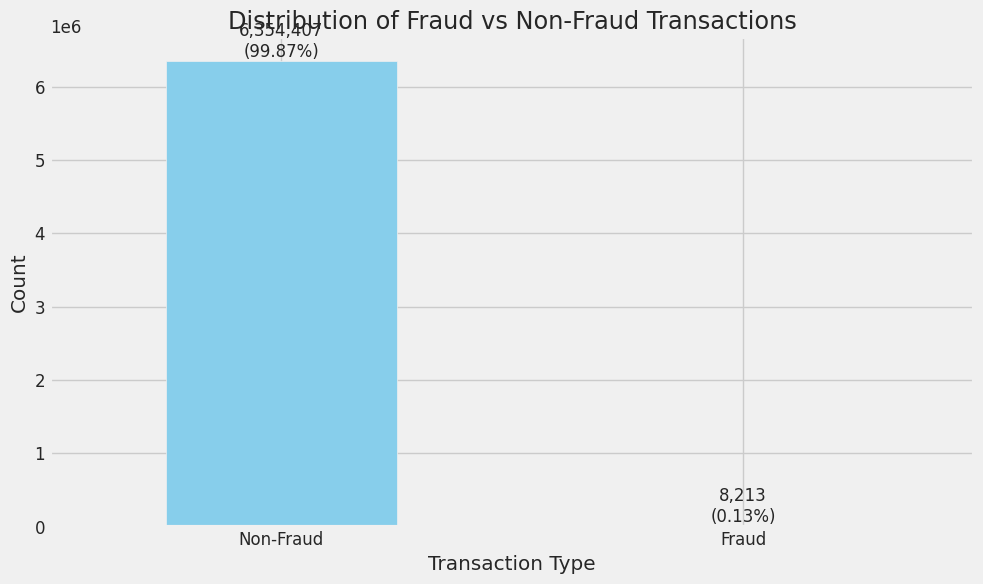

In [4]:
# Class distribution
fraud_counts = raw_data['isFraud'].value_counts()

plt.figure(figsize=(10, 6))
fraud_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'], rotation=0)

# Add count labels on top of each bar
for i, count in enumerate(fraud_counts):
    plt.text(i, count + 0.1, f"{count:,}\n({count/len(raw_data)*100:.2f}%)" , 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

Here we can see perhaps the most important detail of our dataset: Frauds account for 0.13% of the data... This suggests that a model that can work with class imbalance will perform best, and also that we have to stratify the training and testing datasets to account for this

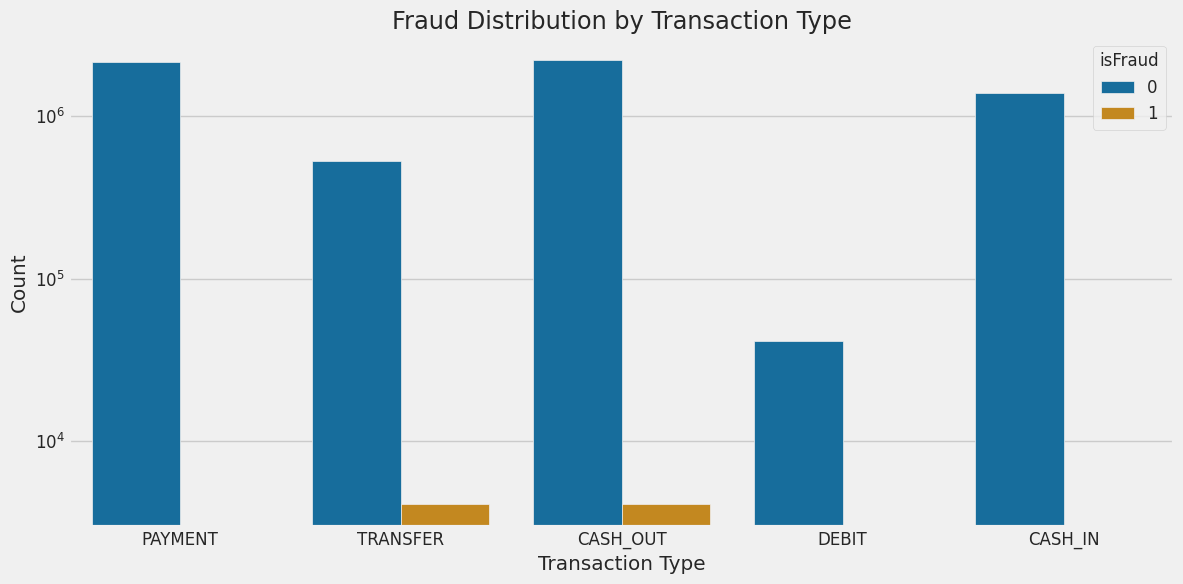

In [5]:
# Transaction type analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='type', hue='isFraud', data=raw_data)
plt.title('Fraud Distribution by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.yscale('log')  # Use log scale for better visualization
plt.tight_layout()
plt.show()

Transfer and cashout operations seem to have the most amount of frauds

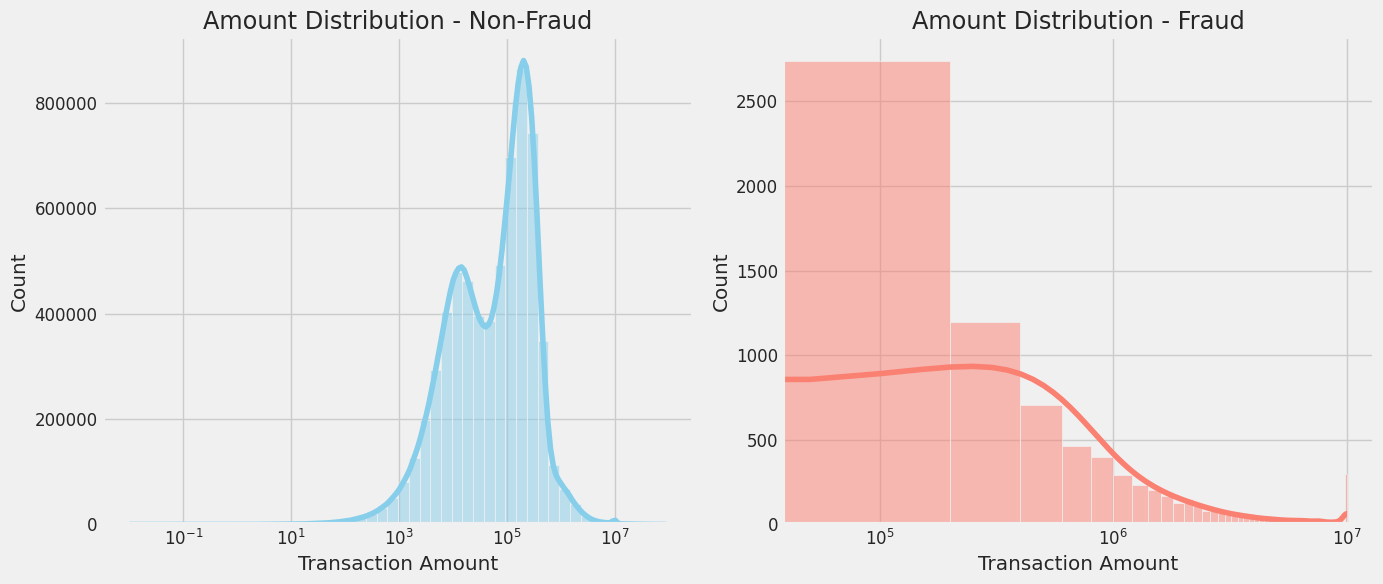

In [10]:
# Amount distribution for fraud vs non-fraud
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(raw_data[raw_data['isFraud']==0]['amount'], bins=50, kde=True, color='skyblue', log_scale=True)
plt.title('Amount Distribution - Non-Fraud')
plt.xlabel('Transaction Amount')
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.histplot(raw_data[raw_data['isFraud']==1]['amount'], bins=50, kde=True, color='salmon', log_scale=True)
plt.title('Amount Distribution - Fraud')
plt.xlabel('Transaction Amount')
plt.xscale('log')

plt.tight_layout()
plt.show()

Here we can see that fraud transactions rarely have low amounts, which hints that amount is another factor that could largely influence our predictions

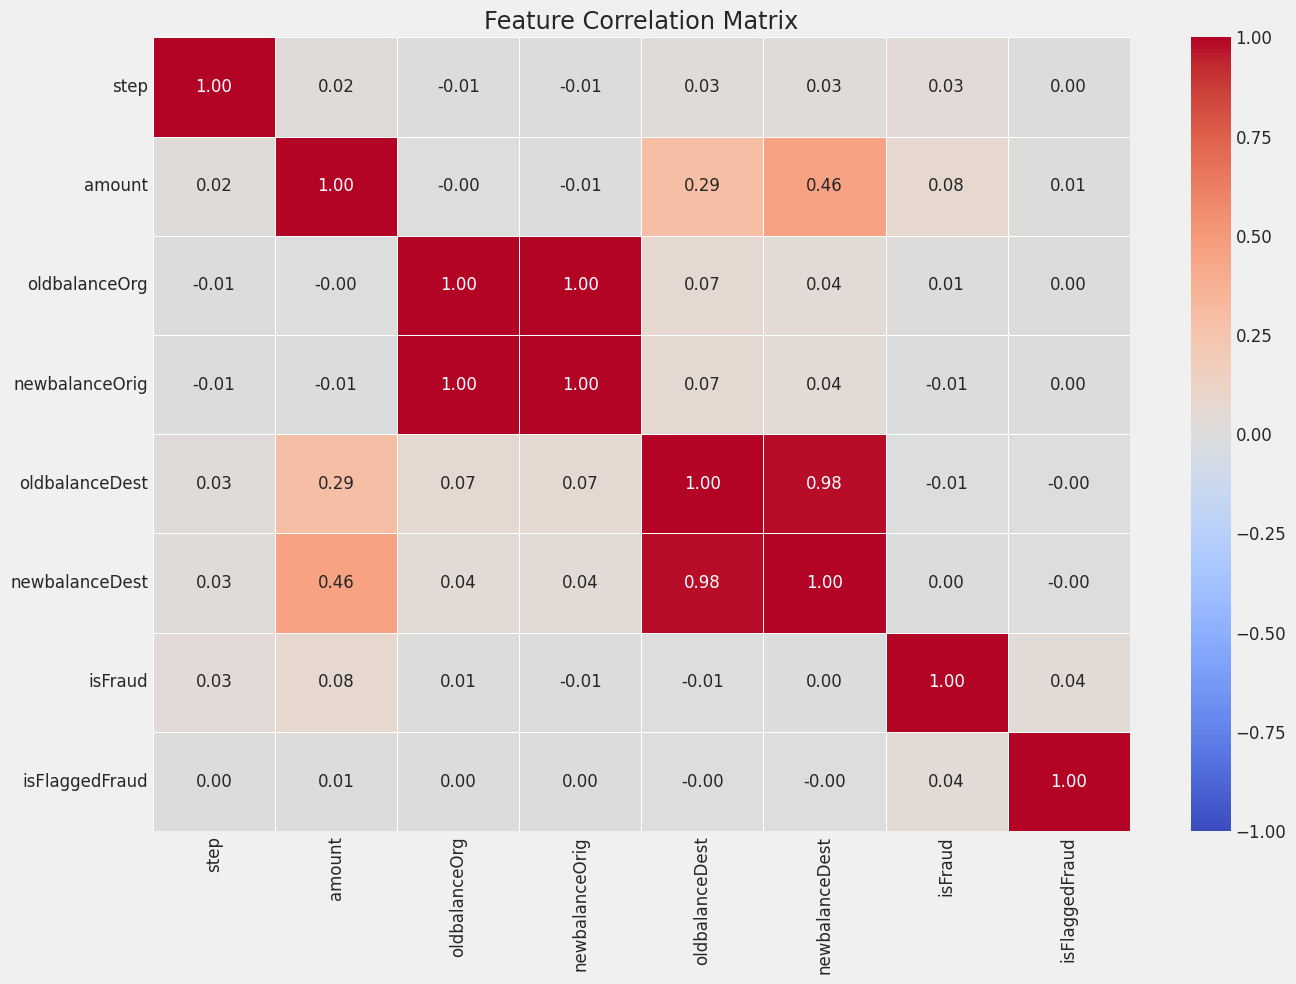

In [11]:
# Feature correlation matrix
# Select only numerical columns
numeric_data = raw_data.select_dtypes(include=[np.number])
correlation = numeric_data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Through this correlation plot, we can see that 'isFlaggedFraud' and 'amount' have the highest correlation to frauds. Other factors have a relatively low correlation to it.
It is also expected that balance metrics have a correlation between them.

## 3. Load Models and Generate Predictions

#### Here we load our already trained models -- LogisticRegression, RandomForest and XGBClassifier and store the results for analysis

In [14]:
# Function to load models and generate predictions
def load_models_and_predict():
    results = {}
    model_predictions = {}
    model_probabilities = {}

    # Check if models directory exists
    if not os.path.exists('models'):
        print("Models directory not found. Please train models first.")
        return None, None, None

    for file in os.listdir('models'):
        if file.endswith('.pkl'):
            # Load model
            model = joblib.load(f"models/{file}")
            model_name = file.replace('.pkl', '')

            # Generate predictions
            y_pred = model.predict(X_test)

            # Generate probabilities if the model supports it
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                model_probabilities[model_name] = y_proba
            except:
                print(f"{model_name} doesn't support probability prediction.")
                model_probabilities[model_name] = None

            # Store predictions
            model_predictions[model_name] = y_pred

            # Calculate metrics
            cm = confusion_matrix(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            # Store results
            results[model_name] = {
                'confusion_matrix': cm,
                'report': report
            }

    return results, model_predictions, model_probabilities

# Load models and get predictions
results, predictions, probabilities = load_models_and_predict()

## 4. Model Performance Visualization

#### Plotting the model results on our test dataset helps us evaluate how each model performs.

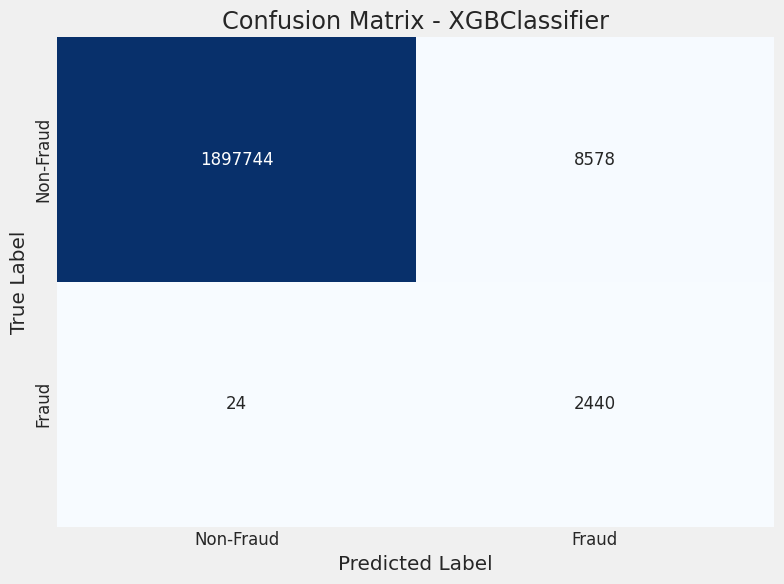

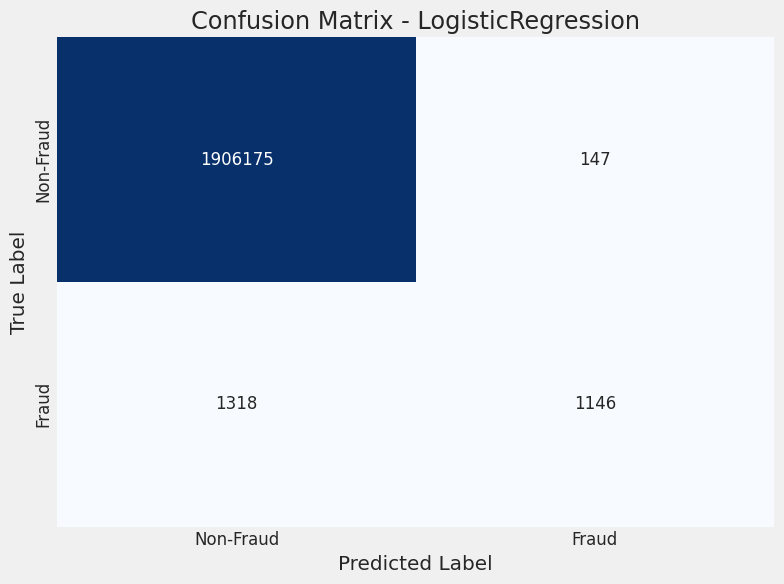

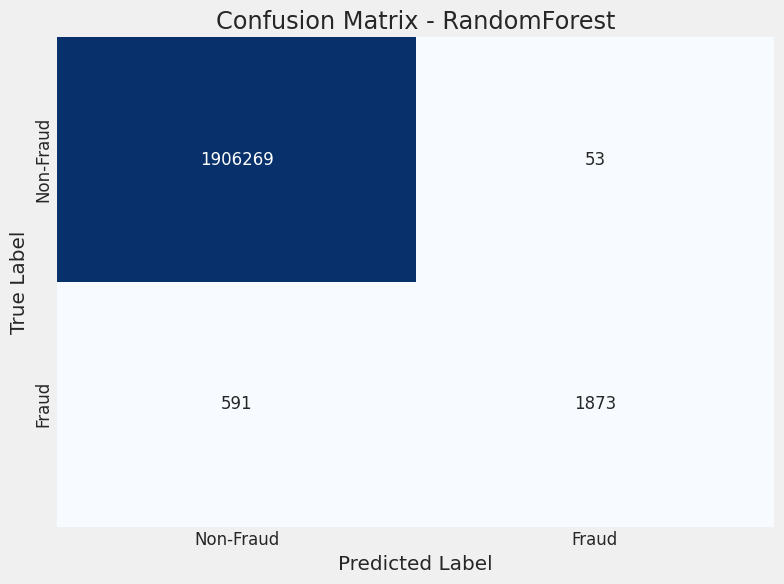

In [15]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Non-Fraud', 'Fraud'])
    plt.yticks([0.5, 1.5], ['Non-Fraud', 'Fraud'])
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for each model
if results:
    for model_name, model_results in results.items():
        plot_confusion_matrix(model_results['confusion_matrix'], model_name)

#### We can see that XGBClassifier identifies the most amount of frauds, at the cost of precision. For every fraud detected, the models also gives 4 false positives, which are legitimate transactions. For this type of problem this is expected, though. Some papers list 1:5 and 1:8 ratios of true to false positives, depending on the type of transaction. Depending on the cost of manually verifying each transaction, this can be a deal breaker though. For the purpose of this study, we'll assume that this ratio is manageable.
#### Random Forest also gives as a decent result, identifying only 53 false positives, a much lower rate than XGBClassifier, but it misses a lot of fraud transactions
#### Of the 3 models, Logistic Regression performs the worst, due to the structure of the data and the class imbalance between fraud and non-fraud transactions. It's recall rate is about 50%, much lower than the other two models, with higher false positives than Random Forest, for example.

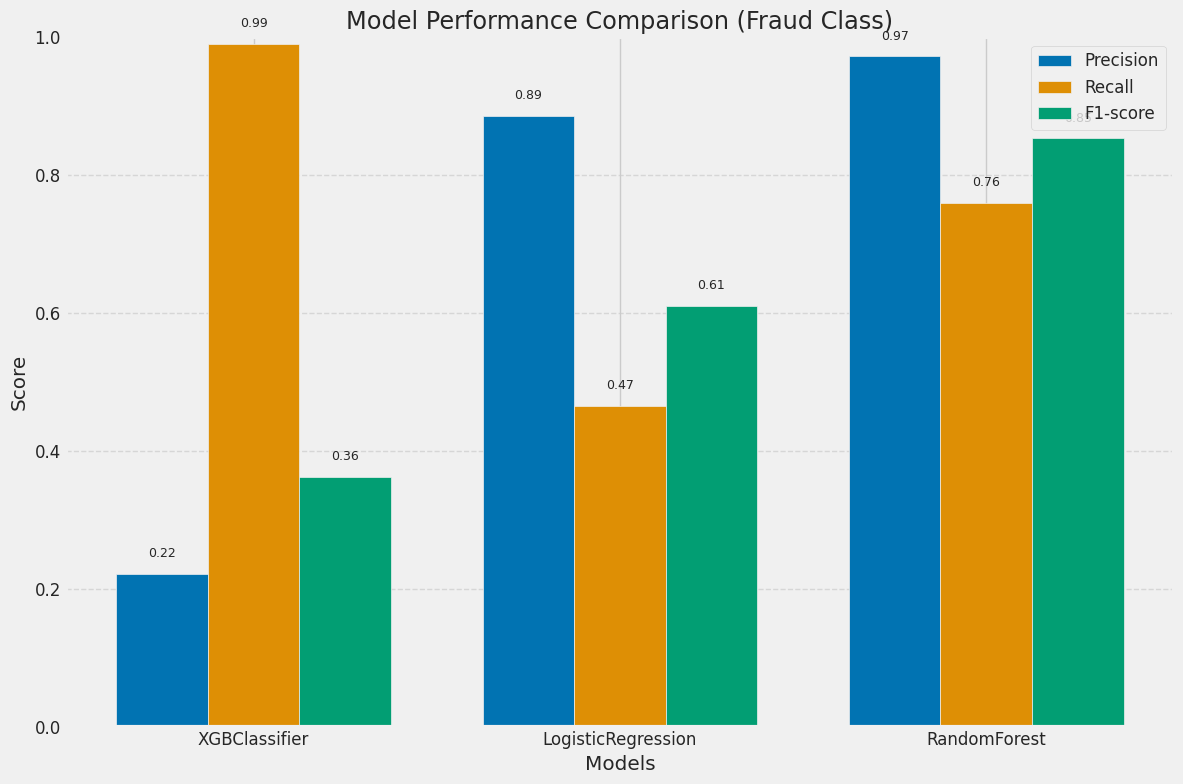

In [16]:
# Compare key metrics across models
def plot_metrics_comparison():
    if not results:
        return
        
    metrics = ['precision', 'recall', 'f1-score']
    model_names = list(results.keys())
    
    # Extract metrics for class 1 (fraud)
    metric_values = {
        'precision': [results[model]['report']['1']['precision'] for model in model_names],
        'recall': [results[model]['report']['1']['recall'] for model in model_names],
        'f1-score': [results[model]['report']['1']['f1-score'] for model in model_names]
    }
    
    # Create bar chart
    plt.figure(figsize=(12, 8))
    x = np.arange(len(model_names))
    width = 0.25
    
    # Plot bars for each metric
    for i, metric in enumerate(metrics):
        plt.bar(x + (i - 1) * width, metric_values[metric], width, label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison (Fraud Class)')
    plt.xticks(x, model_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, metric in enumerate(metrics):
        for j, value in enumerate(metric_values[metric]):
            plt.text(j + (i - 1) * width, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Plot metrics comparison
plot_metrics_comparison()

#### This plot summarizes the performance of the models. We can see that although XGBClassifier has a low precision rating (23%), it has by far the highest recall (99%), which is by far the most important metric for this problem. Random Forest trails with 76% recall and a 97% precision, and can be an alternative model in case we're worried about the number of false positives.

## 5. Feature Importance Analysis

#### In this section we can see what we already discussed previously: Transfer and cashout transaction types and features related to amount are the most important for determining if a transcation is fraudulent.

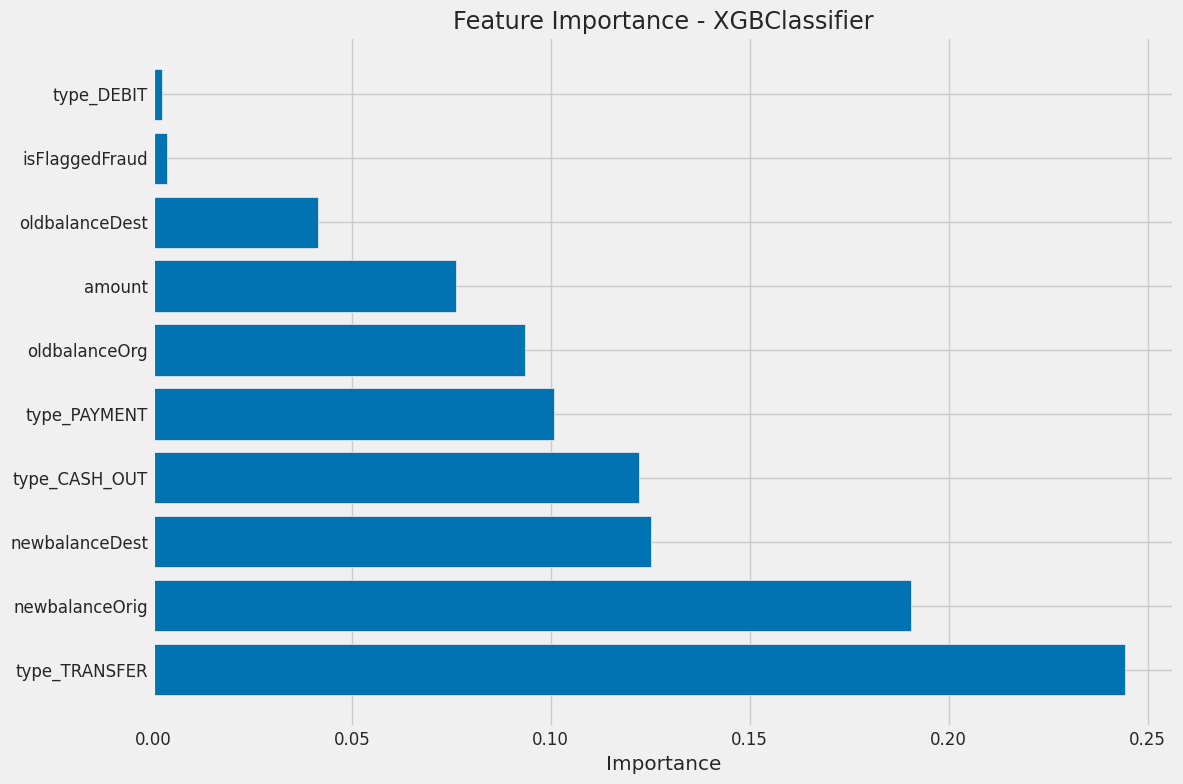

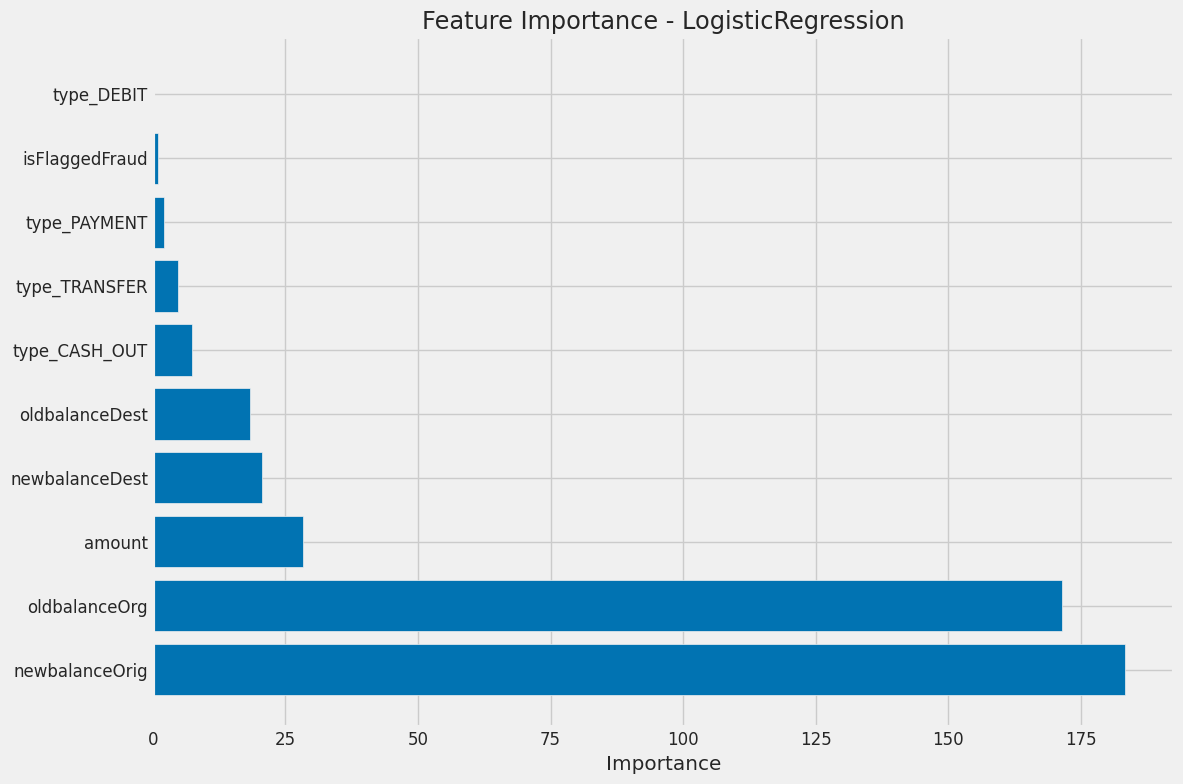

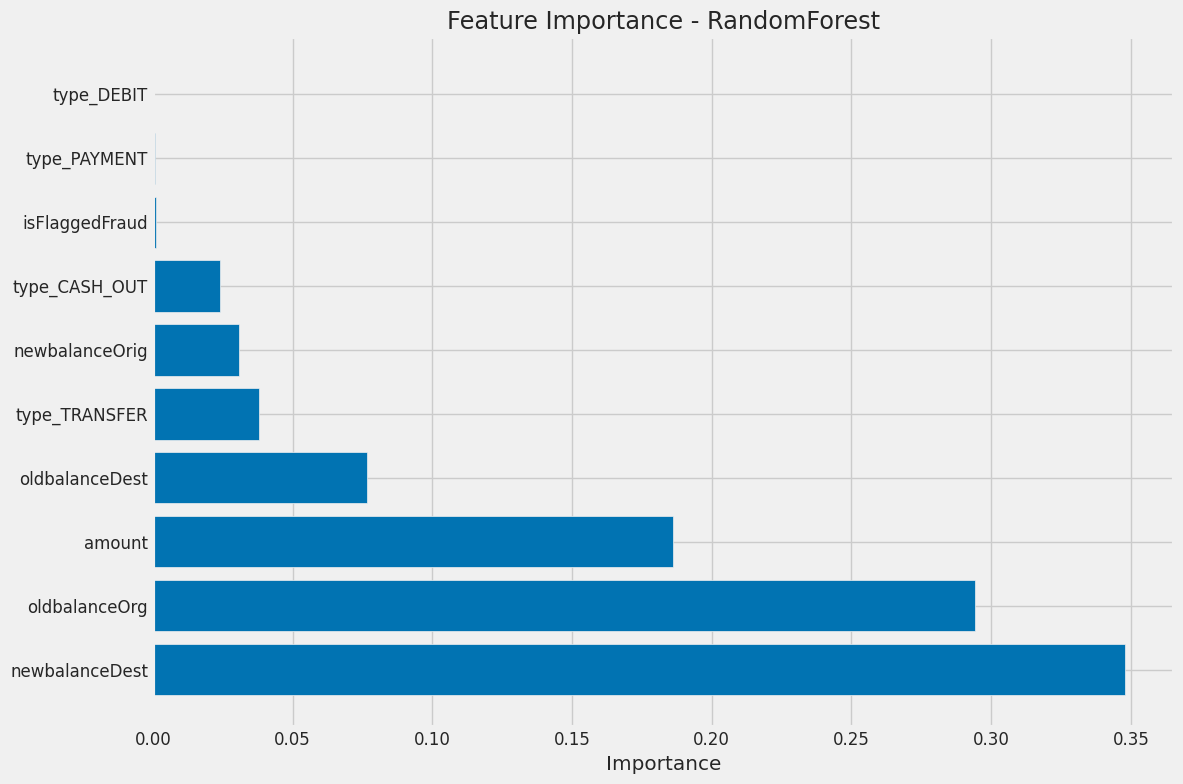

In [19]:
# Get feature importance from models that support it
def plot_feature_importance():
    if not os.path.exists('models'):
        print("Models directory not found.")
        return
        
    for file in os.listdir('models'):
        if file.endswith('.pkl'):
            model = joblib.load(f"models/{file}")
            model_name = file.replace('.pkl', '')
            
            # Extract feature importance if possible
            feature_importance = None
            
            if model_name == 'RandomForest':
                # For Random Forest
                try:
                    feature_importance = model.best_estimator_.named_steps['classifier'].feature_importances_
                except:
                    continue
            elif model_name == 'XGBClassifier':
                # For XGBoost
                try:
                    feature_importance = model.best_estimator_.named_steps['classifier'].feature_importances_
                except:
                    continue
            elif model_name == 'LogisticRegression':
                # For Logistic Regression
                try:
                    coef = model.best_estimator_.named_steps['classifier'].coef_[0]
                    feature_importance = np.abs(coef)
                    
                    # If feature selection was used, we need to map back to original features
                    if 'feature_selection' in model.best_estimator_.named_steps:
                        fs = model.best_estimator_.named_steps['feature_selection']
                        if hasattr(fs, 'get_support'):
                            mask = fs.get_support()
                            temp_importance = np.zeros(len(mask))
                            temp_importance[mask] = feature_importance
                            feature_importance = temp_importance
                except:
                    continue
            
            if feature_importance is not None:
                # Plot feature importance
                feature_names = X.columns
                
                # Make sure feature_importance has the right length
                if len(feature_importance) == len(feature_names):
                    # Sort by importance
                    indices = np.argsort(feature_importance)[::-1]
                    top_indices = indices[:15]  # Show top 15 features
                    
                    plt.figure(figsize=(12, 8))
                    plt.title(f'Feature Importance - {model_name}')
                    plt.barh(range(len(top_indices)), feature_importance[top_indices], align='center')
                    plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
                    plt.xlabel('Importance')
                    plt.tight_layout()
                    plt.show()

# Plot feature importance
plot_feature_importance()

## Conclusions

#### To summarize, throught this analysis we can see that XGBClassifier would be the best model for this problem, unless the cost of verifying transactions indentified as fraud is too high. Through research we can see that a 1:4 ratio is not that bad, but this could vary depending on specific circunstances.
#### For more information on how the models are trained, please access the repository on Github and read the documentation. For suggestions, feel free to reach out